In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
from numpy import linalg
import copy
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from arch import arch_model

In [2]:
market_train_df = pd.read_csv('market_train_df.csv')

In [3]:
market_train_df.head()

,Unnamed: 0,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe
0,0,2007-02-01 22:00:00+00:00,A.N,Agilent Technologies Inc,2606900.0,32.19,32.17,0.005938,0.005312,NaN,NaN,-0.001860,0.000622,NaN,NaN,0.034672,1.0
1,1,2007-02-01 22:00:00+00:00,AAI.N,AirTran Holdings Inc,2051600.0,11.12,11.08,0.004517,-0.007168,NaN,NaN,-0.078708,-0.088066,NaN,NaN,0.027803,0.0
2,2,2007-02-01 22:00:00+00:00,AAP.N,Advance Auto Parts Inc,1164800.0,37.51,37.99,-0.011594,0.025648,NaN,NaN,0.014332,0.045405,NaN,NaN,0.024433,1.0
3,3,2007-02-01 22:00:00+00:00,AAPL.O,Apple Inc,23747329.0,84.74,86.23,-0.011548,0.016324,NaN,NaN,-0.048613,-0.037182,NaN,NaN,-0.007425,1.0
4,4,2007-02-01 22:00:00+00:00,ABB.N,ABB Ltd,1208600.0,18.02,18.01,0.011791,0.025043,NaN,NaN,0.012929,0.020397,NaN,NaN,-0.017994,1.0


# Outlier filter

In [4]:
market_train_df = market_train_df[market_train_df['returnsClosePrevRaw1']>-0.4]
market_train_df = market_train_df[market_train_df['returnsClosePrevRaw1']< 0.4]
market_train_df = market_train_df[market_train_df['returnsOpenPrevRaw1']>-0.4]
market_train_df = market_train_df[market_train_df['returnsOpenPrevRaw1']< 0.4]
market_train_df = market_train_df[market_train_df['returnsOpenNextMktres10']>=-1.0]
market_train_df = market_train_df[market_train_df['returnsOpenNextMktres10']<  2.0]

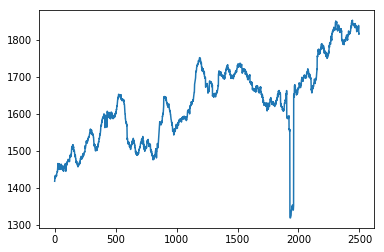

In [5]:
count = 0
count_list = []
curr_date = market_train_df['time'][0]
for date in market_train_df['time']:
    if date == curr_date:
        count+=1
    else:
        count_list.append(count)
        curr_date = date
        count = 1
count_list.append(count)
plt.plot(count_list)

In [6]:
assetCodeSet = set(market_train_df['assetCode'])

In [7]:
len(assetCodeSet)

3780

In [8]:
assetSectorMap = {}

In [9]:
# Generate a pseudo asset to sector mapping
# Need to be replaced be true asset to sector mapping
for asset in assetCodeSet:
    assetSectorMap[asset] = 'sector'+str(random.randint(0,9))

(array([374., 392., 368., 384., 407., 357., 386., 356., 400., 356.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

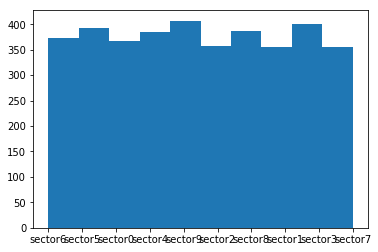

In [10]:
plt.hist(assetSectorMap.values())

In [11]:
sectorCode = [assetSectorMap[asset] for asset in market_train_df['assetCode']]

In [12]:
market_train_df['sectorCode'] = sectorCode

In [13]:
market_train_df.head()

,Unnamed: 0,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe,sectorCode
0,0,2007-02-01 22:00:00+00:00,A.N,Agilent Technologies Inc,2606900.0,32.19,32.17,0.005938,0.005312,NaN,NaN,-0.001860,0.000622,NaN,NaN,0.034672,1.0,sector6
1,1,2007-02-01 22:00:00+00:00,AAI.N,AirTran Holdings Inc,2051600.0,11.12,11.08,0.004517,-0.007168,NaN,NaN,-0.078708,-0.088066,NaN,NaN,0.027803,0.0,sector1
2,2,2007-02-01 22:00:00+00:00,AAP.N,Advance Auto Parts Inc,1164800.0,37.51,37.99,-0.011594,0.025648,NaN,NaN,0.014332,0.045405,NaN,NaN,0.024433,1.0,sector8
3,3,2007-02-01 22:00:00+00:00,AAPL.O,Apple Inc,23747329.0,84.74,86.23,-0.011548,0.016324,NaN,NaN,-0.048613,-0.037182,NaN,NaN,-0.007425,1.0,sector2
4,4,2007-02-01 22:00:00+00:00,ABB.N,ABB Ltd,1208600.0,18.02,18.01,0.011791,0.025043,NaN,NaN,0.012929,0.020397,NaN,NaN,-0.017994,1.0,sector5


In [14]:
market_train_df['volumeScaledreturnsOpenPrevRaw10'] = market_train_df['volume']*market_train_df['returnsOpenPrevRaw10']

In [15]:
sumScaledReturns = market_train_df.groupby(['time','sectorCode'])['volumeScaledreturnsOpenPrevRaw10'].sum()

In [16]:
sumVolume = market_train_df.groupby(['time','sectorCode'])['volume'].sum()

In [17]:
weightedSectorReturns = sumScaledReturns/sumVolume

In [18]:
SectorReturns = {}
for i in range(len(weightedSectorReturns)):
    SectorReturns['sector'+str(i%10)] = SectorReturns.get('sector'+str(i%10),[])+[weightedSectorReturns.iloc[i]]

In [19]:
SectorReturns = pd.DataFrame(SectorReturns)

In [20]:
SectorReturns.head()

,sector0,sector1,sector2,sector3,sector4,sector5,sector6,sector7,sector8,sector9
0,0.023548,0.024580,0.007275,0.014680,0.018677,0.019633,0.028536,0.031875,0.016038,0.020161
1,0.027228,0.030756,0.012585,0.017199,0.026823,0.026306,0.044123,0.035846,0.030470,0.024006
2,0.070709,0.028129,0.039366,0.004744,0.023306,0.018165,0.037110,0.040045,0.018985,0.023545
3,0.058552,0.041369,0.019367,0.015303,0.035288,0.030799,0.049837,0.034384,0.041228,0.032521
4,0.033819,0.016518,0.020368,0.018243,0.046663,0.028547,0.037021,0.029246,0.027245,0.027971


# Forecasting correlations

## Correlation structure

In [21]:
totalCorr = SectorReturns.corr()

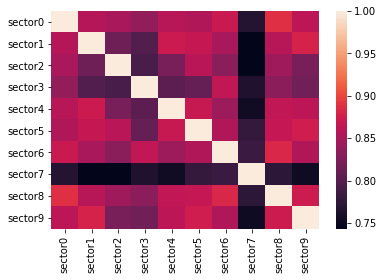

In [22]:
sns.heatmap(totalCorr)

In [23]:
totaleigval = linalg.eig(totalCorr)[0]
totaleigval.sort()
totaleigval

array([0.10116188, 0.10744   , 0.12283276, 0.12575329, 0.13924327,
       0.14920861, 0.20676711, 0.23482978, 0.31852895, 8.49423436])

In [24]:
# Choose a time window to calculate correlation matrix
# Notice the window length should be the same as that for variance calculation
CorrMatRoll = SectorReturns.rolling(20).corr().dropna()

In [25]:
# Apply Ledoit-Wolf shrinkage
shrinkage_factor = 0.2
CorrMatRoll = (1-shrinkage_factor)*CorrMatRoll + shrinkage_factor*np.array(list(np.identity(10))*(len(CorrMatRoll)//10))

In [26]:
# Eigenvalue demonstrate the structure of correlation matrix
ordered_eigenvalues = {}
eigenvalue_series = []
fnorm_deviation_initial = []
fnorm_deviation_previous = []
for i in range(0,len(CorrMatRoll),10):
    window = CorrMatRoll.iloc[i:(i+10),]
    fnorm_deviation_initial.append(linalg.norm(window.reset_index(drop=True)-CorrMatRoll.iloc[:10,].reset_index(drop=True)))
    if i>0:
        fnorm_deviation_previous.append(linalg.norm(window.reset_index(drop=True)-prev_window.reset_index(drop=True)))
    Corr = window.corr()
    eigval = linalg.eig(Corr)[0]
    eigval.sort()
    eigenvalue_series.append(eigval)
    for j in range(10):
        ordered_eigenvalues[j] = ordered_eigenvalues.get(j,[])+[eigval[j]]
    prev_window = window

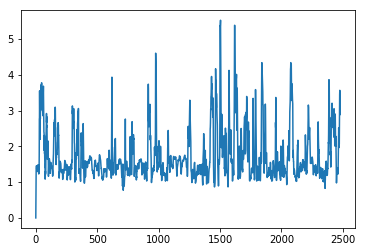

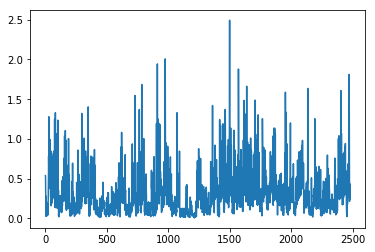

In [27]:
plt.plot(fnorm_deviation_initial)
plt.show()
plt.plot(fnorm_deviation_previous)
plt.show()

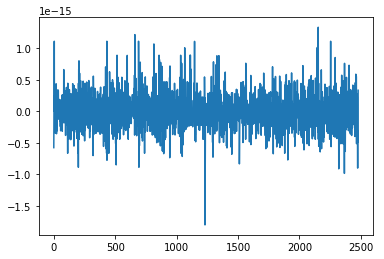

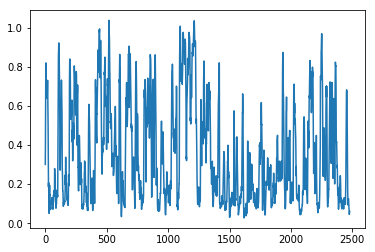

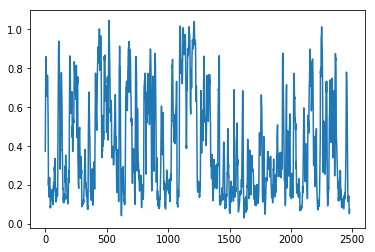

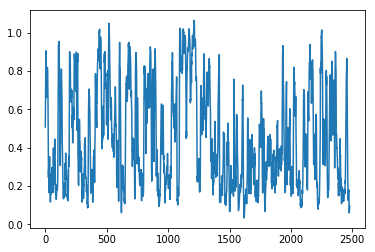

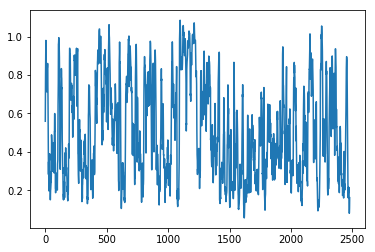

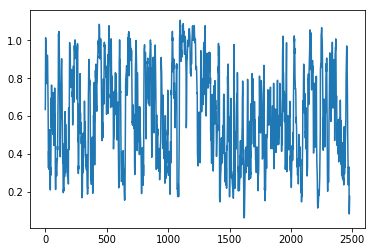

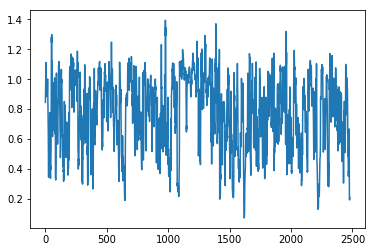

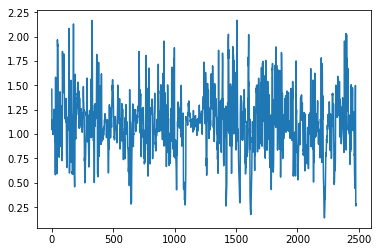

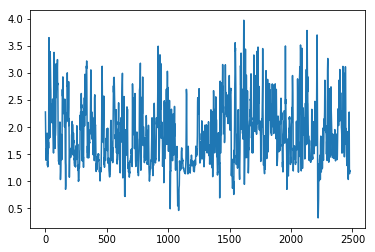

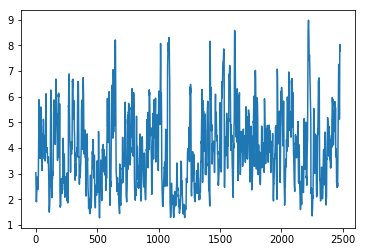

In [28]:
for i in range(10):
    plt.plot(ordered_eigenvalues[i])
    plt.show()

## The condition number is generally very large
## Need some shrinkage

C:\Users\georg\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.


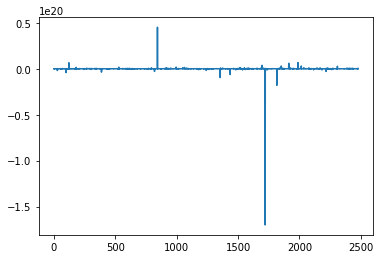

In [29]:
condition_number = [i/j for i,j in zip(ordered_eigenvalues[9],ordered_eigenvalues[0])]
plt.plot(condition_number)
plt.show()

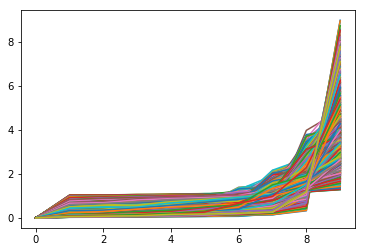

In [30]:
for series in eigenvalue_series:
    plt.plot(series)
plt.show()

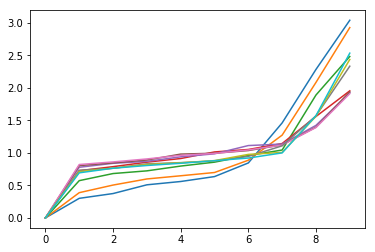

In [31]:
for series in eigenvalue_series[:10]:
    plt.plot(series)
plt.show()

## Correlation forecasting using EWMA

In [32]:
CorrMatRoll.shape

(24790, 10)

In [33]:
CorrMatRoll

sector0   sector1   sector2   sector3   sector4   sector5  \
19   sector0  1.000000  0.643902  0.723612  0.523369  0.614710  0.559635   
     sector1  0.643902  1.000000  0.648495  0.680679  0.686928  0.656461   
     sector2  0.723612  0.648495  1.000000  0.619249  0.657540  0.603312   
     sector3  0.523369  0.680679  0.619249  1.000000  0.696065  0.708491   
     sector4  0.614710  0.686928  0.657540  0.696065  1.000000  0.689003   
     sector5  0.559635  0.656461  0.603312  0.708491  0.689003  1.000000   
     sector6  0.649595  0.773707  0.660006  0.703934  0.707830  0.663985   
     sector7  0.517106  0.625024  0.612555  0.552822  0.522186  0.585897   
     sector8  0.573145  0.696198  0.612359  0.671853  0.686971  0.638256   
     sector9  0.451494  0.547033  0.512328  0.686596  0.599555  0.684172   
20   sector0  1.000000  0.691419  0.740081  0.602313  0.658796  0.620549   
     sector1  0.691419  1.000000  0.701676  0.719431  0.730399  0.706866   
     sector2  0.740081  0.701676  1.000000  0.682284  0.700419  0.664533   
     sector3  0.602313  0.719431  0.682284  1.000000  0.737722  0.743956   
     sector4  0.658796  0.730399  0.700419  0.737722  1.000000  0.726760   
     sector5  0.620549  0.706866  0.664533  0.743956  0.726760  1.000000   
     sector6  0.688963  0.781554  0.701194  0.729328  0.735604  0.703150   
     sector7  0.592617  0.661676  0.668265  0.607766  0.599281  0.641387   
     sector8  0.625630  0.738532  0.664444  0.718981  0.719815  0.687864   
     sector9  0.540332  0.640493  0.601426  0.736822  0.667241  0.725910   
21   sector0  1.000000  0.746453  0.765465  0.694072  0.714765  0.703833   
     sector1  0.746453  1.000000  0.745753  0.750743  0.759075  0.744743   
     sector2  0.765465  0.745753  1.000000  0.733184  0.737609  0.722079   
     sector3  0.694072  0.750743  0.733184  1.000000  0.760571  0.769049   
     sector4  0.714765  0.759075  0.737609  0.760571  1.000000  0.752061   
     sector5  0.703833  0.744743  0.722079  0.769049  0.752061  1.000000   
     sector6  0.752597  0.788710  0.750949  0.760137  0.765938  0.747655   
     sector7  0.675228  0.701530  0.717747  0.667871  0.666300  0.691436   
     sector8  0.694939  0.761888  0.714925  0.747200  0.747976  0.727438   
     sector9  0.648160  0.711966  0.681428  0.768044  0.718375  0.759188   
...                ...       ...       ...       ...       ...       ...   
2495 sector0  1.000000 -0.244434 -0.197609 -0.233277 -0.159551 -0.159575   
     sector1 -0.244434  1.000000  0.654600  0.637366  0.721056  0.631123   
     sector2 -0.197609  0.654600  1.000000  0.696717  0.741959  0.736561   
     sector3 -0.233277  0.637366  0.696717  1.000000  0.687095  0.678110   
     sector4 -0.159551  0.721056  0.741959  0.687095  1.000000  0.679745   
     sector5 -0.159575  0.631123  0.736561  0.678110  0.679745  1.000000   
     sector6 -0.220178  0.615381  0.655260  0.641694  0.587759  0.698314   
     sector7 -0.030260  0.395573  0.613709  0.565955  0.532117  0.682268   
     sector8 -0.144351  0.345543  0.514852  0.465247  0.484707  0.536182   
     sector9 -0.280440  0.762873  0.693250  0.704820  0.739932  0.673349   
2496 sector0  1.000000 -0.143940 -0.098513 -0.152946 -0.067872 -0.039372   
     sector1 -0.143940  1.000000  0.693100  0.655925  0.731283  0.643553   
     sector2 -0.098513  0.693100  1.000000  0.704410  0.753663  0.751530   
     sector3 -0.152946  0.655925  0.704410  1.000000  0.693778  0.681229   
     sector4 -0.067872  0.731283  0.753663  0.693778  1.000000  0.686684   
     sector5 -0.039372  0.643553  0.751530  0.681229  0.686684  1.000000   
     sector6 -0.117719  0.622039  0.681416  0.652716  0.600493  0.704988   
     sector7  0.016454  0.402094  0.613112  0.569036  0.533942  0.665970   
     sector8 -0.040193  0.384565  0.551969  0.488925  0.512873  0.570502   
     sector9 -0.180094  0.762253  0.729595  0.722336  0.749776  0.682808   
2497 sector0  1.000000 -0.080453 -0.027571 -0.080058 -0.026538 

In [34]:
CorrMatRollForecast = copy.deepcopy(CorrMatRoll)

In [35]:
CorrMatRollForecast

sector0   sector1   sector2   sector3   sector4   sector5  \
19   sector0  1.000000  0.643902  0.723612  0.523369  0.614710  0.559635   
     sector1  0.643902  1.000000  0.648495  0.680679  0.686928  0.656461   
     sector2  0.723612  0.648495  1.000000  0.619249  0.657540  0.603312   
     sector3  0.523369  0.680679  0.619249  1.000000  0.696065  0.708491   
     sector4  0.614710  0.686928  0.657540  0.696065  1.000000  0.689003   
     sector5  0.559635  0.656461  0.603312  0.708491  0.689003  1.000000   
     sector6  0.649595  0.773707  0.660006  0.703934  0.707830  0.663985   
     sector7  0.517106  0.625024  0.612555  0.552822  0.522186  0.585897   
     sector8  0.573145  0.696198  0.612359  0.671853  0.686971  0.638256   
     sector9  0.451494  0.547033  0.512328  0.686596  0.599555  0.684172   
20   sector0  1.000000  0.691419  0.740081  0.602313  0.658796  0.620549   
     sector1  0.691419  1.000000  0.701676  0.719431  0.730399  0.706866   
     sector2  0.740081  0.701676  1.000000  0.682284  0.700419  0.664533   
     sector3  0.602313  0.719431  0.682284  1.000000  0.737722  0.743956   
     sector4  0.658796  0.730399  0.700419  0.737722  1.000000  0.726760   
     sector5  0.620549  0.706866  0.664533  0.743956  0.726760  1.000000   
     sector6  0.688963  0.781554  0.701194  0.729328  0.735604  0.703150   
     sector7  0.592617  0.661676  0.668265  0.607766  0.599281  0.641387   
     sector8  0.625630  0.738532  0.664444  0.718981  0.719815  0.687864   
     sector9  0.540332  0.640493  0.601426  0.736822  0.667241  0.725910   
21   sector0  1.000000  0.746453  0.765465  0.694072  0.714765  0.703833   
     sector1  0.746453  1.000000  0.745753  0.750743  0.759075  0.744743   
     sector2  0.765465  0.745753  1.000000  0.733184  0.737609  0.722079   
     sector3  0.694072  0.750743  0.733184  1.000000  0.760571  0.769049   
     sector4  0.714765  0.759075  0.737609  0.760571  1.000000  0.752061   
     sector5  0.703833  0.744743  0.722079  0.769049  0.752061  1.000000   
     sector6  0.752597  0.788710  0.750949  0.760137  0.765938  0.747655   
     sector7  0.675228  0.701530  0.717747  0.667871  0.666300  0.691436   
     sector8  0.694939  0.761888  0.714925  0.747200  0.747976  0.727438   
     sector9  0.648160  0.711966  0.681428  0.768044  0.718375  0.759188   
...                ...       ...       ...       ...       ...       ...   
2495 sector0  1.000000 -0.244434 -0.197609 -0.233277 -0.159551 -0.159575   
     sector1 -0.244434  1.000000  0.654600  0.637366  0.721056  0.631123   
     sector2 -0.197609  0.654600  1.000000  0.696717  0.741959  0.736561   
     sector3 -0.233277  0.637366  0.696717  1.000000  0.687095  0.678110   
     sector4 -0.159551  0.721056  0.741959  0.687095  1.000000  0.679745   
     sector5 -0.159575  0.631123  0.736561  0.678110  0.679745  1.000000   
     sector6 -0.220178  0.615381  0.655260  0.641694  0.587759  0.698314   
     sector7 -0.030260  0.395573  0.613709  0.565955  0.532117  0.682268   
     sector8 -0.144351  0.345543  0.514852  0.465247  0.484707  0.536182   
     sector9 -0.280440  0.762873  0.693250  0.704820  0.739932  0.673349   
2496 sector0  1.000000 -0.143940 -0.098513 -0.152946 -0.067872 -0.039372   
     sector1 -0.143940  1.000000  0.693100  0.655925  0.731283  0.643553   
     sector2 -0.098513  0.693100  1.000000  0.704410  0.753663  0.751530   
     sector3 -0.152946  0.655925  0.704410  1.000000  0.693778  0.681229   
     sector4 -0.067872  0.731283  0.753663  0.693778  1.000000  0.686684   
     sector5 -0.039372  0.643553  0.751530  0.681229  0.686684  1.000000   
     sector6 -0.117719  0.622039  0.681416  0.652716  0.600493  0.704988   
     sector7  0.016454  0.402094  0.613112  0.569036  0.533942  0.665970   
     sector8 -0.040193  0.384565  0.551969  0.488925  0.512873  0.570502   
     sector9 -0.180094  0.762253  0.729595  0.722336  0.749776  0.682808   
2497 sector0  1.000000 -0.080453 -0.027571 -0.080058 -0.026538 

In [36]:
CorrMatRollForecast.reset_index(inplace = True)

In [37]:
CorrMatRollForecast

,level_0,level_1,sector0,sector1,sector2,sector3,sector4,sector5,sector6,sector7,sector8,sector9
0,19,sector0,1.000000,0.643902,0.723612,0.523369,0.614710,0.559635,0.649595,0.517106,0.573145,0.451494
1,19,sector1,0.643902,1.000000,0.648495,0.680679,0.686928,0.656461,0.773707,0.625024,0.696198,0.547033
2,19,sector2,0.723612,0.648495,1.000000,0.619249,0.657540,0.603312,0.660006,0.612555,0.612359,0.512328
3,19,sector3,0.523369,0.680679,0.619249,1.000000,0.696065,0.708491,0.703934,0.552822,0.671853,0.686596
4,19,sector4,0.614710,0.686928,0.657540,0.696065,1.000000,0.689003,0.707830,0.522186,0.686971,0.599555
5,19,sector5,0.559635,0.656461,0.603312,0.708491,0.689003,1.000000,0.663985,0.585897,0.638256,0.684172
6,19,sector6,0.649595,0.773707,0.660006,0.703934,0.707830,0.663985,1.000000,0.632539,0.680748,0.547652
7,19,sector7,0.517106,0.625024,0.612555,0.552822,0.522186,0.585897,0.632539,1.000000,0.462123,0.442911
8,19,sector8,0.573145,0.696198,0.612359,0.671853,0.686971,0.638256,0.680748,0.462123,1.000000,0.585941
9,19,sector9,0.451494,0.547033,0.512328,0.686596,0.599555,0.684172,0.547652,0.442911,0.585941,1.000000


In [38]:
CorrMatRollForecast.columns = ['date','sector']+['sector'+str(i) for i in range(10)]

In [39]:
CorrMatRollForecast.columns

Index([u'date', u'sector', u'sector0', u'sector1', u'sector2', u'sector3',
       u'sector4', u'sector5', u'sector6', u'sector7', u'sector8', u'sector9'],
      dtype='object')

In [40]:
CorrMatRollForecast.sort_values(by = ['sector','date'],inplace= True)

In [41]:
CorrMatRollForecast.head()

,date,sector,sector0,sector1,sector2,sector3,sector4,sector5,sector6,sector7,sector8,sector9
0,19,sector0,1.0,0.643902,0.723612,0.523369,0.614710,0.559635,0.649595,0.517106,0.573145,0.451494
10,20,sector0,1.0,0.691419,0.740081,0.602313,0.658796,0.620549,0.688963,0.592617,0.625630,0.540332
20,21,sector0,1.0,0.746453,0.765465,0.694072,0.714765,0.703833,0.752597,0.675228,0.694939,0.648160
30,22,sector0,1.0,0.765515,0.769455,0.750315,0.757857,0.757019,0.772303,0.695366,0.756590,0.715770
40,23,sector0,1.0,0.768514,0.778618,0.761467,0.759603,0.765651,0.771673,0.699528,0.763413,0.736983


In [42]:
CorrMatRollForecast.set_index(['sector','date'],inplace = True)

In [43]:
CorrMatRollForecast = CorrMatRollForecast.groupby('sector').apply(lambda x: x.ewm(alpha = 0.99).mean())

In [44]:
CorrMatRollForecast

sector0   sector1   sector2   sector3   sector4   sector5  \
sector  date                                                               
sector0 19    1.000000  0.643902  0.723612  0.523369  0.614710  0.559635   
        20    1.000000  0.690948  0.739918  0.601532  0.658359  0.619946   
        21    1.000000  0.745898  0.765210  0.693147  0.714201  0.702994   
        22    1.000000  0.765319  0.769412  0.749744  0.757421  0.756479   
        23    1.000000  0.768482  0.778526  0.761350  0.759581  0.765560   
        24    1.000000  0.770938  0.781139  0.765034  0.764701  0.769251   
        25    1.000000  0.771898  0.778673  0.767183  0.768124  0.771986   
        26    1.000000  0.703929  0.728180  0.718123  0.698241  0.698170   
        27    1.000000  0.702843  0.727610  0.714840  0.693505  0.693986   
        28    1.000000  0.702615  0.725888  0.711903  0.690724  0.691158   
        29    1.000000  0.690596  0.719357  0.702544  0.681159  0.684340   
        30    1.000000  0.677027  0.705599  0.690915  0.667511  0.680864   
        31    1.000000  0.681056  0.710126  0.704245  0.665030  0.686280   
        32    1.000000  0.691246  0.717416  0.713490  0.679628  0.696069   
        33    1.000000  0.697437  0.721589  0.718035  0.683603  0.702457   
        34    1.000000  0.702732  0.727309  0.721842  0.690656  0.706947   
        35    1.000000  0.686616  0.729561  0.721613  0.690660  0.706922   
        36    1.000000  0.684793  0.726516  0.722759  0.691519  0.707055   
        37    1.000000  0.680618  0.722266  0.716667  0.692280  0.706132   
        38    1.000000  0.673157  0.712970  0.709587  0.685208  0.706899   
        39    1.000000  0.657951  0.709442  0.707864  0.685689  0.708589   
        40    1.000000  0.646723  0.705967  0.707363  0.685448  0.707634   
        41    1.000000  0.606318  0.678994  0.683034  0.648805  0.689172   
        42    1.000000  0.565459  0.648564  0.657052  0.613280  0.666159   
        43    1.000000  0.492492  0.607144  0.625077  0.571789  0.642086   
        44    1.000000  0.367171  0.539562  0.565797  0.512337  0.592316   
        45    1.000000  0.206853  0.460987  0.455725  0.394509  0.521962   
        46    1.000000  0.260767  0.612583  0.543758  0.514359  0.715877   
        47    1.000000  0.152568  0.594502  0.492947  0.466654  0.725911   
        48    1.000000  0.006493  0.566376  0.475278  0.452111  0.747791   
...                ...       ...       ...       ...       ...       ...   
sector9 2468  0.740260  0.676613  0.644679  0.743931  0.735726  0.748909   
        2469  0.756751  0.713521  0.676150  0.756481  0.749471  0.759424   
        2470  0.763308  0.741050  0.693223  0.762127  0.753980  0.759559   
        2471  0.765780  0.757172  0.703384  0.764735  0.758401  0.762759   
        2472  0.766716  0.765665  0.704233  0.767744  0.759047  0.765831   
        2473  0.764002  0.778215  0.706803  0.768959  0.760384  0.760788   
        2474  0.763102  0.782151  0.706169  0.768089  0.760157  0.760095   
        2475  0.759395  0.779171  0.703942  0.768378  0.778077  0.761197   
        2476  0.750342  0.763802  0.702538  0.767647  0.776972  0.760056   
        2477  0.737383  0.734079  0.695716  0.767636  0.760126  0.760877   
        2478  0.732859  0.716139  0.690482  0.756365  0.735610  0.756944   
        2479  0.726708  0.645310  0.690555  0.747651  0.698089  0.751597   
        2480  0.721075  0.558749  0.676459  0.736843  0.648760  0.729973   
        2481  0.694868  0.436917  0.619882  0.708671  0.581915  0.704786   
        2482  0.676131  0.344640  0.575252  0.694082  0.525200  0.688326   
        2483  0.675264  0.339011  0.571828  0.703978  0.458851  0.683648   
        2484  0.668014  0.346186  0.564538  0.709856  0.362455  0.681614   
        2485  0.683614  0.311475  0.539715  0.738423  0.284934  0.692131   
        2486  0.709585  0.390741  0.519749  0.731111  0.276437  0.657530   
        2487  0.708173  0.496912  0.581881  0.722985  0.398190 

In [45]:
CorrMatRollForecast.reset_index(inplace = True)

In [46]:
CorrMatRollForecast = CorrMatRollForecast.sort_values(by = ['date','sector'])

In [47]:
CorrMatRollForecast

,sector,date,sector0,sector1,sector2,sector3,sector4,sector5,sector6,sector7,sector8,sector9
0,sector0,19,1.000000,0.643902,0.723612,0.523369,0.614710,0.559635,0.649595,0.517106,0.573145,0.451494
2479,sector1,19,0.643902,1.000000,0.648495,0.680679,0.686928,0.656461,0.773707,0.625024,0.696198,0.547033
4958,sector2,19,0.723612,0.648495,1.000000,0.619249,0.657540,0.603312,0.660006,0.612555,0.612359,0.512328
7437,sector3,19,0.523369,0.680679,0.619249,1.000000,0.696065,0.708491,0.703934,0.552822,0.671853,0.686596
9916,sector4,19,0.614710,0.686928,0.657540,0.696065,1.000000,0.689003,0.707830,0.522186,0.686971,0.599555
12395,sector5,19,0.559635,0.656461,0.603312,0.708491,0.689003,1.000000,0.663985,0.585897,0.638256,0.684172
14874,sector6,19,0.649595,0.773707,0.660006,0.703934,0.707830,0.663985,1.000000,0.632539,0.680748,0.547652
17353,sector7,19,0.517106,0.625024,0.612555,0.552822,0.522186,0.585897,0.632539,1.000000,0.462123,0.442911
19832,sector8,19,0.573145,0.696198,0.612359,0.671853,0.686971,0.638256,0.680748,0.462123,1.000000,0.585941
22311,sector9,19,0.451494,0.547033,0.512328,0.686596,0.599555,0.684172,0.547652,0.442911,0.585941,1.000000


In [48]:
CorrMatRollForecast.set_index(['date','sector'],inplace = True)

In [49]:
ewma_error = []
prev_error = []
for i in range(10,len(CorrMatRoll),10):
    ewma_error.append(linalg.norm(CorrMatRollForecast.iloc[(i-10):i,:].reset_index(drop=True)-CorrMatRoll.iloc[i:(i+10),:].reset_index(drop=True)))
    prev_error.append(linalg.norm(CorrMatRoll.iloc[(i-10):i,:].reset_index(drop=True)-CorrMatRoll.iloc[i:(i+10),:].reset_index(drop=True)))

## Simple EWMA cannot beat previous prediction

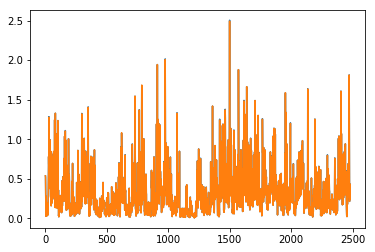

In [50]:
plt.plot(ewma_error)
plt.plot(prev_error)
plt.show()

In [51]:
print(np.mean(ewma_error))
print(np.mean(prev_error))

0.3153753463433596
0.31385587296680445


# Forecasting variances

In [52]:
SectorReturns.head()

,sector0,sector1,sector2,sector3,sector4,sector5,sector6,sector7,sector8,sector9
0,0.023548,0.024580,0.007275,0.014680,0.018677,0.019633,0.028536,0.031875,0.016038,0.020161
1,0.027228,0.030756,0.012585,0.017199,0.026823,0.026306,0.044123,0.035846,0.030470,0.024006
2,0.070709,0.028129,0.039366,0.004744,0.023306,0.018165,0.037110,0.040045,0.018985,0.023545
3,0.058552,0.041369,0.019367,0.015303,0.035288,0.030799,0.049837,0.034384,0.041228,0.032521
4,0.033819,0.016518,0.020368,0.018243,0.046663,0.028547,0.037021,0.029246,0.027245,0.027971


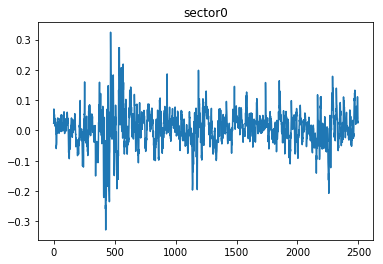

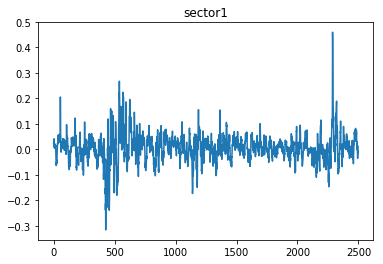

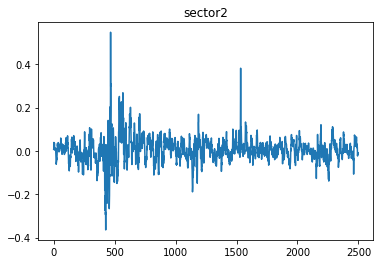

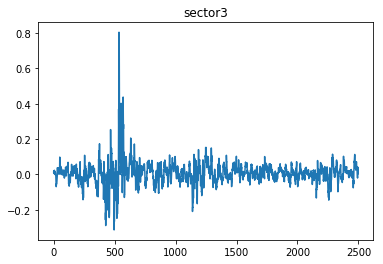

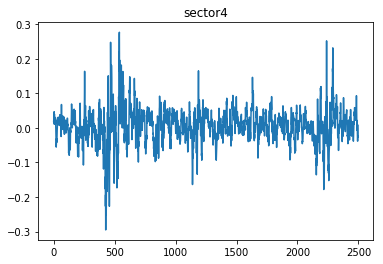

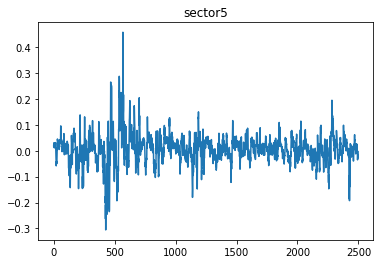

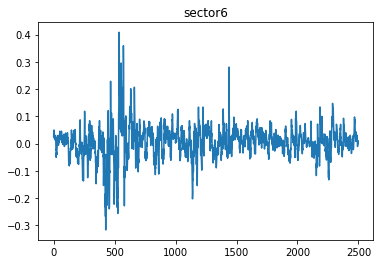

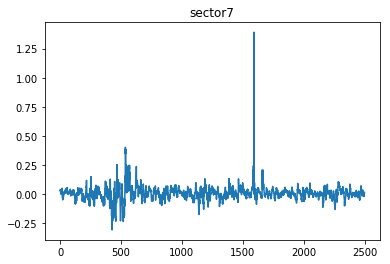

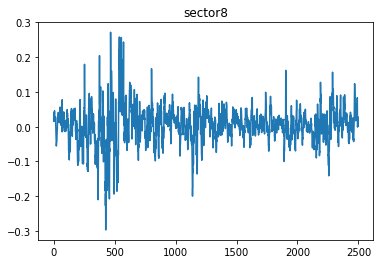

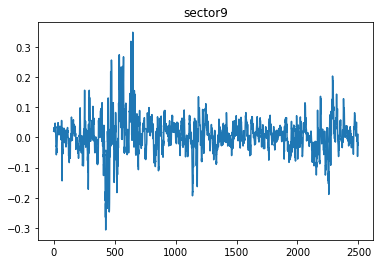

In [53]:
for i in range(10):
    plt.plot(SectorReturns['sector'+str(i)])
    plt.title('sector'+str(i))
    plt.show()

In [54]:
VarianceRoll = SectorReturns.rolling(20).var().dropna()

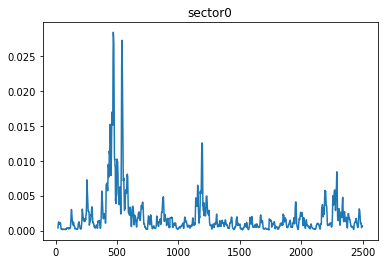

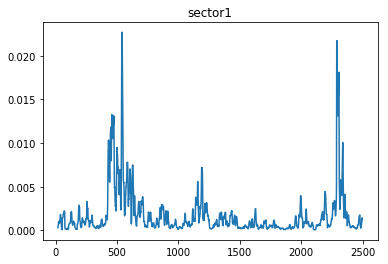

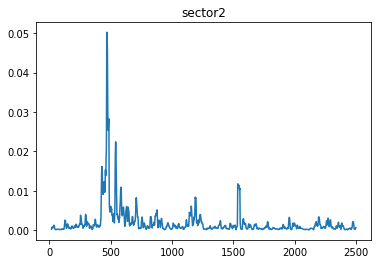

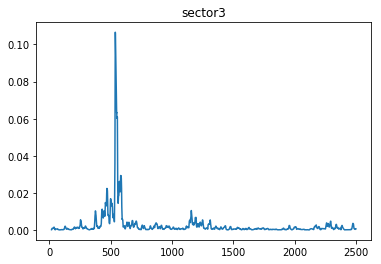

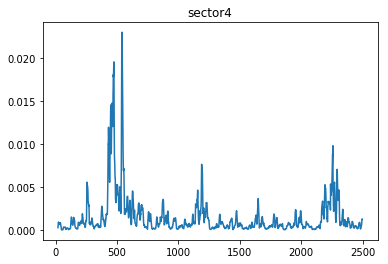

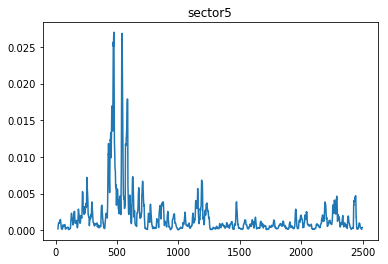

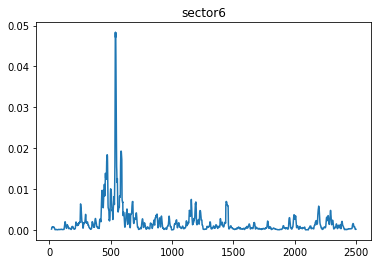

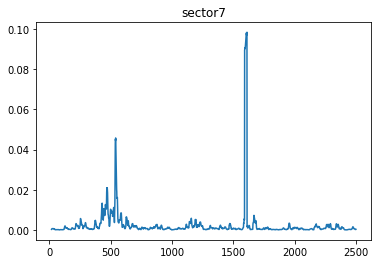

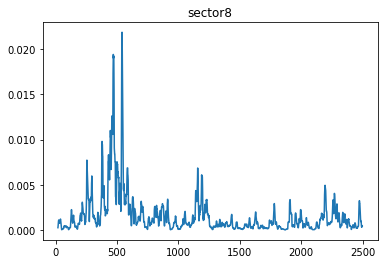

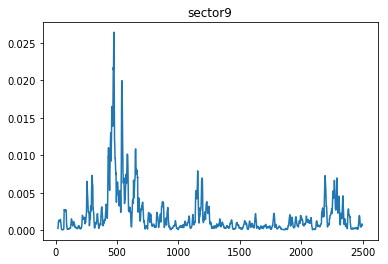

In [55]:
for i in range(10):
    plt.plot(VarianceRoll['sector'+str(i)])
    plt.title('sector'+str(i))
    plt.show()

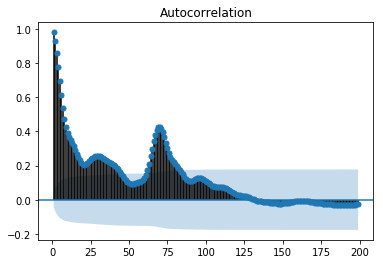

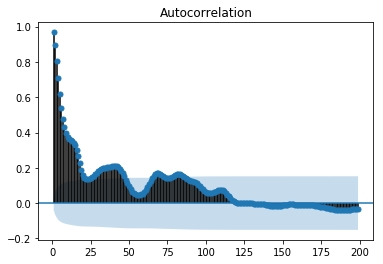

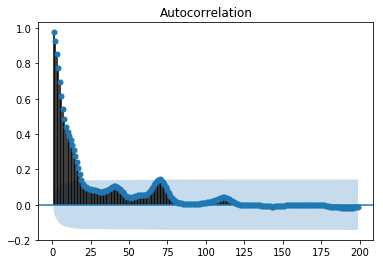

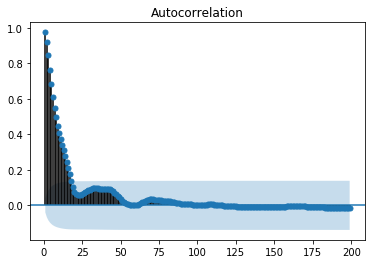

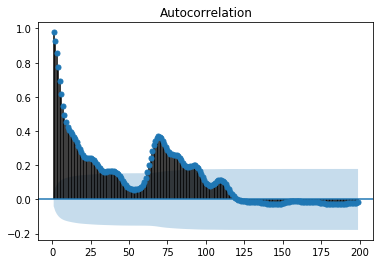

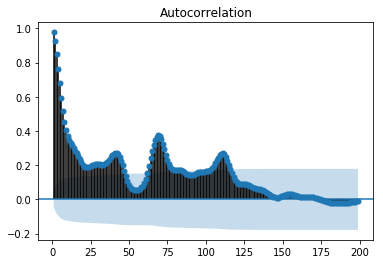

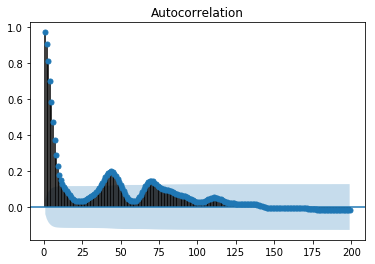

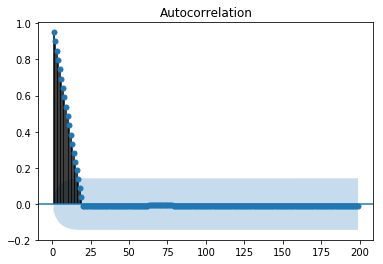

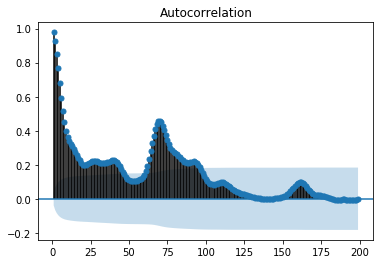

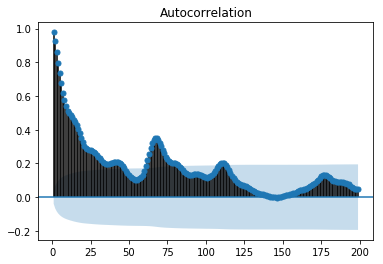

In [56]:
# ACF of squared data
for i in range(10):
    plot_acf(VarianceRoll['sector'+str(i)]**2,lags = [i for i in range(1,200)])

In [ ]:
n_test = len(VarianceRoll)//10

## Fit ARCH model

Fitting ARCH for Sector 0
Iteration:      1,   Func. Count:    103,   Neg. LLF: -3578.93109069
Iteration:      2,   Func. Count:    207,   Neg. LLF: -3857.20881761
Iteration:      3,   Func. Count:    311,   Neg. LLF: -3894.5608868
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3894.56089362
            Iterations: 7
            Function evaluations: 311
            Gradient evaluations: 3


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


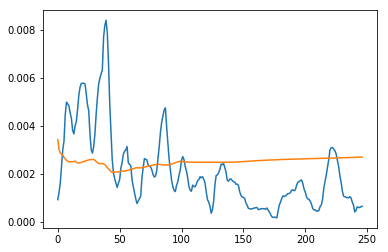

Fitting ARCH for Sector 1
Iteration:      1,   Func. Count:    103,   Neg. LLF: -3855.69233507
Iteration:      2,   Func. Count:    210,   Neg. LLF: -3864.9518499
Iteration:      3,   Func. Count:    314,   Neg. LLF: -4027.11461834
Iteration:      4,   Func. Count:    418,   Neg. LLF: -4082.88807519
Iteration:      5,   Func. Count:    522,   Neg. LLF: -4127.76933766
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4127.76934441
            Iterations: 9
            Function evaluations: 522
            Gradient evaluations: 5


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


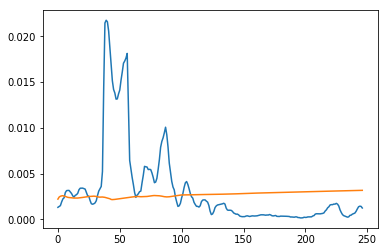

Fitting ARCH for Sector 2
Iteration:      1,   Func. Count:    103,   Neg. LLF: -3633.93114394
Iteration:      2,   Func. Count:    210,   Neg. LLF: -3642.34494681
Iteration:      3,   Func. Count:    314,   Neg. LLF: -3896.4364892
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3896.43649622
            Iterations: 7
            Function evaluations: 314
            Gradient evaluations: 3


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


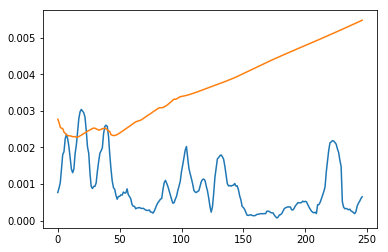

Fitting ARCH for Sector 3
Iteration:      1,   Func. Count:    103,   Neg. LLF: -3633.05244289
Iteration:      2,   Func. Count:    209,   Neg. LLF: -3646.53297301
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3646.5329778
            Iterations: 6
            Function evaluations: 209
            Gradient evaluations: 2


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


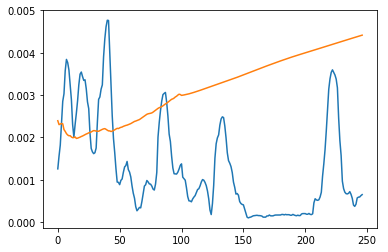

Fitting ARCH for Sector 4
Iteration:      1,   Func. Count:    103,   Neg. LLF: -3883.38016937
Iteration:      2,   Func. Count:    207,   Neg. LLF: -4038.89803938
Iteration:      3,   Func. Count:    311,   Neg. LLF: -4124.56785509
Iteration:      4,   Func. Count:    415,   Neg. LLF: -4179.66710997
Iteration:      5,   Func. Count:    519,   Neg. LLF: -4223.681731
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4223.68173827
            Iterations: 9
            Function evaluations: 519
            Gradient evaluations: 5


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


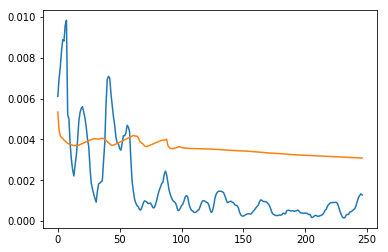

Fitting ARCH for Sector 5
Iteration:      1,   Func. Count:    103,   Neg. LLF: -3717.3012433
Iteration:      2,   Func. Count:    207,   Neg. LLF: -3857.36359858
Iteration:      3,   Func. Count:    311,   Neg. LLF: -3931.53873779
Iteration:      4,   Func. Count:    415,   Neg. LLF: -3984.82042305
Iteration:      5,   Func. Count:    519,   Neg. LLF: -4027.30247207
Iteration:      6,   Func. Count:    623,   Neg. LLF: -4062.8359023
Iteration:      7,   Func. Count:    727,   Neg. LLF: -4093.22923038
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4093.22923796
            Iterations: 11
            Function evaluations: 727
            Gradient evaluations: 7


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


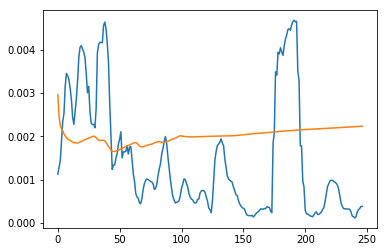

Fitting ARCH for Sector 6
Iteration:      1,   Func. Count:    103,   Neg. LLF: -3587.22724352
Iteration:      2,   Func. Count:    210,   Neg. LLF: -3595.23607899
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3595.23608277
            Iterations: 6
            Function evaluations: 210
            Gradient evaluations: 2


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


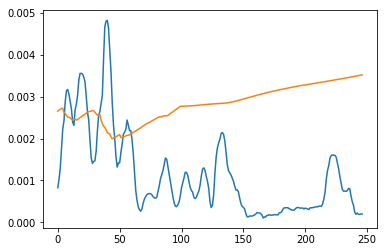

Fitting ARCH for Sector 7
Iteration:      1,   Func. Count:    103,   Neg. LLF: -3418.69974165
Iteration:      2,   Func. Count:    207,   Neg. LLF: -3713.45579839
Iteration:      3,   Func. Count:    314,   Neg. LLF: -3717.50211561
Iteration:      4,   Func. Count:    418,   Neg. LLF: -3829.85895355
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3829.85895898
            Iterations: 8
            Function evaluations: 418
            Gradient evaluations: 4


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


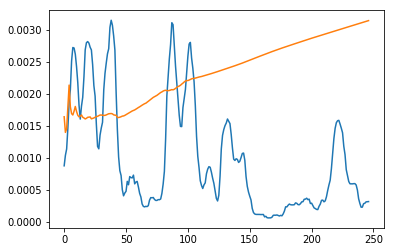

Fitting ARCH for Sector 8
Iteration:      1,   Func. Count:    103,   Neg. LLF: -3861.18747681
Iteration:      2,   Func. Count:    208,   Neg. LLF: -3920.96111237
Iteration:      3,   Func. Count:    312,   Neg. LLF: -3973.76573573
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3973.76574243
            Iterations: 7
            Function evaluations: 312
            Gradient evaluations: 3


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


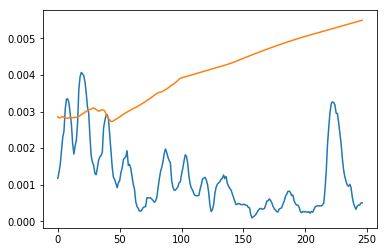

Fitting ARCH for Sector 9
Iteration:      1,   Func. Count:    103,   Neg. LLF: -3677.39016323
Iteration:      2,   Func. Count:    207,   Neg. LLF: -3907.54153821
Iteration:      3,   Func. Count:    311,   Neg. LLF: -3959.22694402
Iteration:      4,   Func. Count:    415,   Neg. LLF: -4000.54872998
Iteration:      5,   Func. Count:    519,   Neg. LLF: -4035.11903771
Iteration:      6,   Func. Count:    623,   Neg. LLF: -4064.65210433
Iteration:      7,   Func. Count:    727,   Neg. LLF: -4090.06089392
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4090.06090079
            Iterations: 11
            Function evaluations: 727
            Gradient evaluations: 7


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


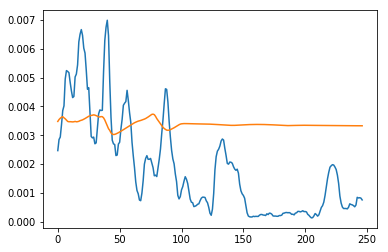

In [60]:
for i in range(10):
    print("Fitting ARCH for Sector "+str(i))
    data = SectorReturns['sector'+str(i)]
    train, test = data[:-n_test], data[-n_test:]
    model = arch_model(train, mean='Zero', vol='ARCH', p=100)
    # fit model
    model_fit = model.fit()
    #print(model_fit.summary())
    # forecast the test set
    yhat = model_fit.forecast(horizon=n_test)
    # plot the actual variance
    plt.plot(VarianceRoll['sector'+str(i)][-n_test:].reset_index(drop = True))
    # plot forecast variance
    plt.plot(yhat.variance.values[-1, :])
    plt.show()

## Fit GARCH model

Fitting ARCH for Sector 0
Iteration:      1,   Func. Count:    203,   Neg. LLF: -3462.06308439
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3462.06308988
            Iterations: 5
            Function evaluations: 203
            Gradient evaluations: 1


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


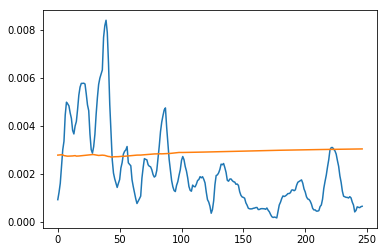

Fitting ARCH for Sector 1
Iteration:      1,   Func. Count:    203,   Neg. LLF: -3709.04554967
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3709.04555598
            Iterations: 5
            Function evaluations: 203
            Gradient evaluations: 1


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


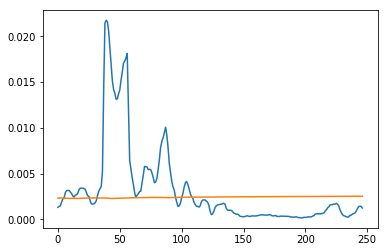

Fitting ARCH for Sector 2
Iteration:      1,   Func. Count:    203,   Neg. LLF: -3455.06231114
Iteration:      2,   Func. Count:    407,   Neg. LLF: -3845.64253535
Iteration:      3,   Func. Count:    611,   Neg. LLF: -3907.9210558
Iteration:      4,   Func. Count:    815,   Neg. LLF: -3958.41006319
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3958.41007783
            Iterations: 8
            Function evaluations: 815
            Gradient evaluations: 4


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


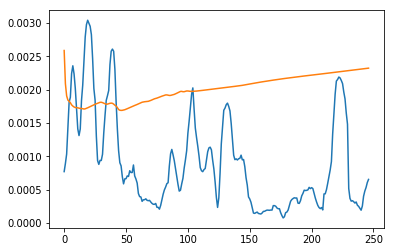

Fitting ARCH for Sector 3
Iteration:      1,   Func. Count:    203,   Neg. LLF: -3343.15567647
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3343.15569591
            Iterations: 5
            Function evaluations: 203
            Gradient evaluations: 1


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


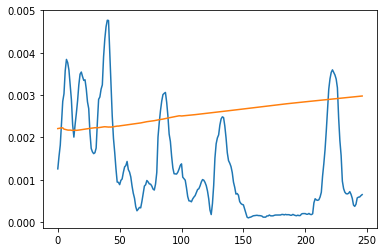

Fitting ARCH for Sector 4
Iteration:      1,   Func. Count:    203,   Neg. LLF: -3773.09097934
Iteration:      2,   Func. Count:    407,   Neg. LLF: -4252.41432271
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4252.41433534
            Iterations: 6
            Function evaluations: 407
            Gradient evaluations: 2


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


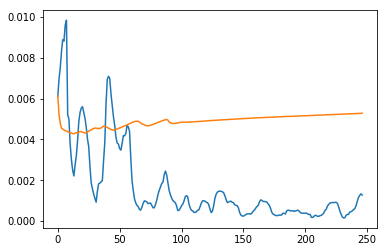

Fitting ARCH for Sector 5
Iteration:      1,   Func. Count:    203,   Neg. LLF: -3556.79020917
Iteration:      2,   Func. Count:    408,   Neg. LLF: -3743.72920296
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3743.72922551
            Iterations: 6
            Function evaluations: 408
            Gradient evaluations: 2


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


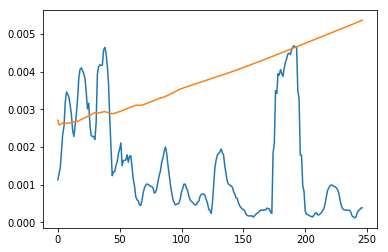

Fitting ARCH for Sector 6
Iteration:      1,   Func. Count:    203,   Neg. LLF: -3445.89813581
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3445.89814664
            Iterations: 5
            Function evaluations: 203
            Gradient evaluations: 1


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


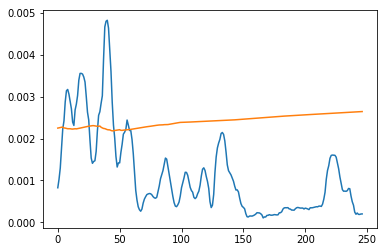

Fitting ARCH for Sector 7
Iteration:      1,   Func. Count:    203,   Neg. LLF: -3206.37019308
Iteration:      2,   Func. Count:    407,   Neg. LLF: -3602.95883698
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3602.95884604
            Iterations: 6
            Function evaluations: 407
            Gradient evaluations: 2


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


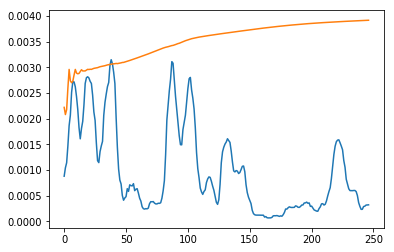

Fitting ARCH for Sector 8
Iteration:      1,   Func. Count:    203,   Neg. LLF: -3727.28033865
Iteration:      2,   Func. Count:    407,   Neg. LLF: -4213.62067243
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4213.62068635
            Iterations: 6
            Function evaluations: 407
            Gradient evaluations: 2


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


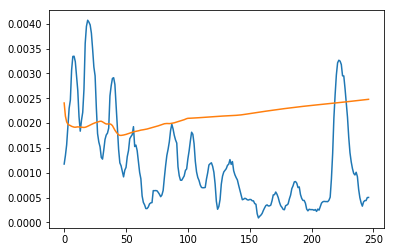

Fitting ARCH for Sector 9
Iteration:      1,   Func. Count:    203,   Neg. LLF: -3516.01582291
Iteration:      2,   Func. Count:    408,   Neg. LLF: -3827.10605571
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3827.10607446
            Iterations: 6
            Function evaluations: 408
            Gradient evaluations: 2


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


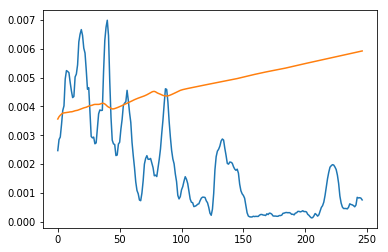

In [61]:
for i in range(10):
    print("Fitting ARCH for Sector "+str(i))
    data = SectorReturns['sector'+str(i)]
    train, test = data[:-n_test], data[-n_test:]
    model = arch_model(train, mean='Zero', vol='GARCH', p=100,q=100)
    # fit model
    model_fit = model.fit()
    #print(model_fit.summary())
    # forecast the test set
    yhat = model_fit.forecast(horizon=n_test)
    # plot the actual variance
    plt.plot(VarianceRoll['sector'+str(i)][-n_test:].reset_index(drop = True))
    # plot forecast variance
    plt.plot(yhat.variance.values[-1, :])
    plt.show()